In [1]:
%load_ext autoreload
%autoreload 2
%cd '../HOTS'
%matplotlib inline

/home/antoine/homhots/HOTS/HOTS


In [2]:
import tonic
from mix_TimeSurface import TimeSurface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import os
import pickle
import datetime
from mix_Network import *

def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox)

# Stream.png

In [3]:
learningset = tonic.datasets.POKERDVS(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/pips_test.tar.gz
Extracting ../Data/pips_test.tar.gz to ../Data/


In [4]:
print(learningset)

Dataset POKERDVS
    Number of datapoints: 20
    Root location: ../Data/


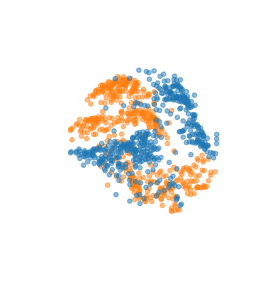

In [5]:
        target_event = 1000
        X_on = []
        Y_on = []
        T_on = []
        X_off = []
        Y_off = []
        T_off = []
        iev = 100
        events, target = next(iter(loader))
        while iev<target_event:
            x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                    events[0][iev][learningset.ordering.find("y")].item(), \
                    events[0][iev][learningset.ordering.find("t")].item(), \
                    events[0][iev][learningset.ordering.find("p")].item()
            if p:
                X_on.append(x)
                Y_on.append(abs(learningset.sensor_size[1]-y))
                T_on.append(t)
            else:
                X_off.append(x)
                Y_off.append(abs(learningset.sensor_size[1]-y))
                T_off.append(t)
            iev+=1
        fig = plt.figure(figsize=(10,5))
        sub1 = fig.add_subplot(1,2,1, projection="3d")
        sub1.scatter(T_on, X_on, Y_on, cmap= plt.cm.plasma, alpha=0.5)
        sub1.scatter(T_off, X_off, Y_off, cmap= plt.cm.plasma, alpha=0.5)
        #sub1.arrow([0,max(T_off)], [0,0], [0,0])
        sub1.view_init(10,-40)
        sub1.grid(b = None)
        sub1.set_xlabel('time')
        sub1.axis('off')
        plt.show()

In [6]:
printfig(fig, 'stream.png')

# Flux.png

In [7]:
learningset = tonic.datasets.NMNIST(save_to='../Data/', train = False,
                                transform=None)
loader = tonic.datasets.DataLoader(learningset, shuffle=True)

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


In [8]:
target_event = 2000
TS = TimeSurface(R=2,tau=5*10e3,camsize=[34,34])
events, target = next(iter(loader))
flxT = TS.spatpmat.copy()
iev = 0
while iev<target_event:
    x,y,t,p = events[0][iev][learningset.ordering.find("x")].item(), \
                events[0][iev][learningset.ordering.find("y")].item(), \
                events[0][iev][learningset.ordering.find("t")].item(), \
                events[0][iev][learningset.ordering.find("p")].item(),
    flxT[p,x,y] = t
    ts, activ = TS.addevent(x,y,t,p)
    iev+=1

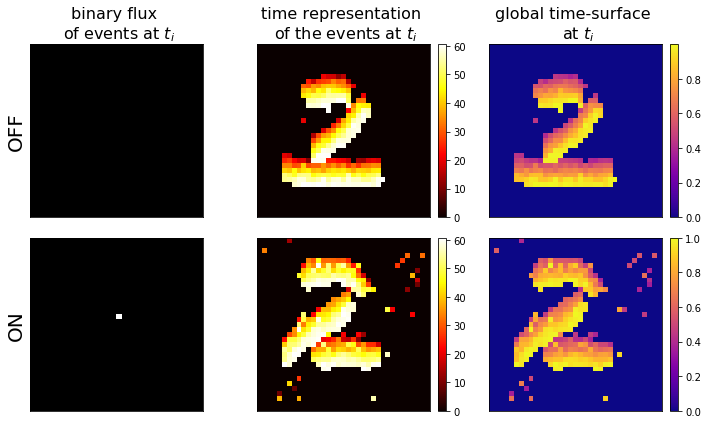

In [9]:
polaritiz = ['OFF','ON']
gamma = 1
fig, axs = plt.subplots(2,3,figsize=(10,6))

Ti = np.zeros(learningset.sensor_size)
singev = axs[abs(p-1),0].imshow(Ti.T, cmap='gray')
axs[abs(p-1),0].set_title('binary flux \n of events at $t_i$', fontsize=16)
axs[abs(p-1),0].set_ylabel(f'{polaritiz[abs(p-1)]}', fontsize=20)
axs[abs(p-1),0].set_xticks(())
axs[abs(p-1),0].set_yticks(())

Ti[x,y] = 1
singev = axs[p,0].imshow(Ti.T, cmap='gray')
#axs[p,0].set_title('binary flux of events at $t_i$', fontsize=16) #for NN
if p==0:
    axs[p,0].set_title('event recording at $t_i$', fontsize=16)
axs[p,0].set_ylabel(f'{polaritiz[p]}', fontsize=20)
axs[p,0].set_xticks(())
axs[p,0].set_yticks(())

for p in [0,1]:
    T = axs[p,1].imshow(flxT[p].T*1e-3, cmap='hot')
    #axs[p,1].set_title('T flux at $t_i$ (in $ms$)', fontsize=16) #for NN
    if p==0:
        axs[p,1].set_title('time representation \n of the events at $t_i$', fontsize=16)
    axs[p,1].set_xticks(())
    axs[p,1].set_yticks(())
    plt.colorbar(T, ax=axs[p,1], fraction=0.046, pad=0.04);
    
    S = axs[p,2].imshow(TS.spatpmat[p].T, cmap=plt.cm.plasma)
    #axs[p,2].set_title('S flux at $t_i$', fontsize=16) #for NN
    if p==0:
        axs[p,2].set_title('global time-surface \n at $t_i$', fontsize=16)
    axs[p,2].set_xticks(())
    axs[p,2].set_yticks(())
    cbar = plt.colorbar(S, ax=axs[p,2], fraction=0.046, pad=0.04);
    #cbar.set_label(fonsize=16)
    
fig.tight_layout()

In [10]:
printfig(fig, 'flux.png')

# Layers.png

In [11]:
dataset = 'nmnist'
records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2021-01-06'

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = 1
pooling = False
homeinv = False
jitter = False
tau = 5
nb_train = 5000
nb_test = 100
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2

hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learningall(dataset=dataset)

../Records/nmnist/models/2021-02-08_lagorce_rdn_1_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8].pkl
no jitter
Using downloaded and verified file: ../Data/nmnist_train.zip
Extracting ../Data/nmnist_train.zip to ../Data/


  0%|          | 0/20 [00:00<?, ?it/s]

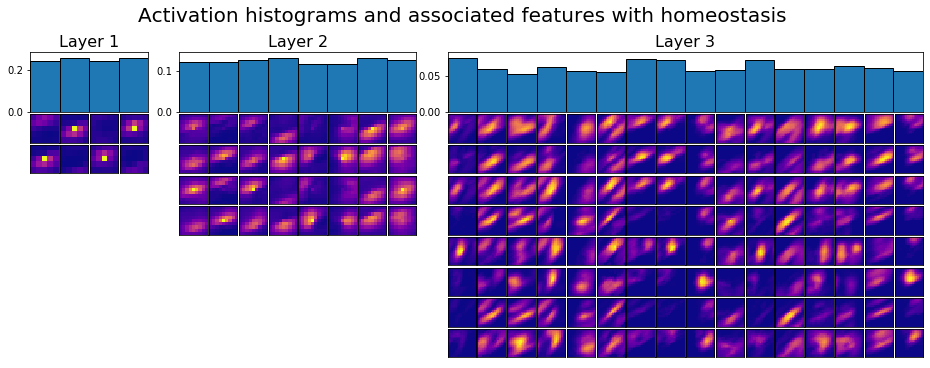

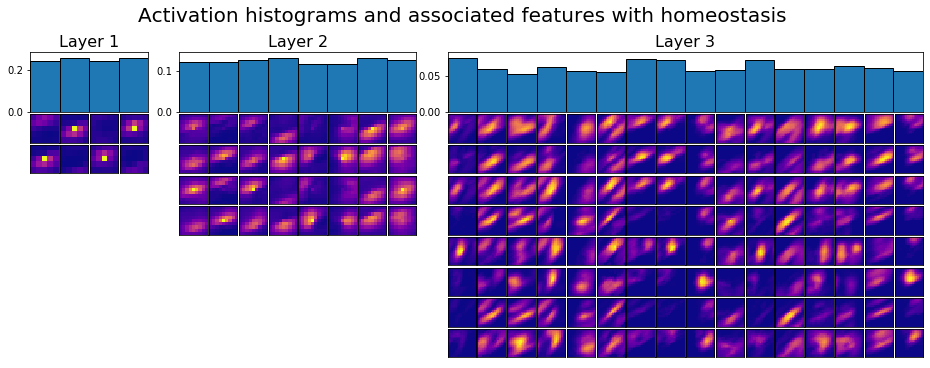

In [12]:
hotshom.plotlayer()

In [13]:
printfig(fig, 'layerwiz.png')

In [14]:
homeo = False
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learningall(dataset=dataset)

../Records/nmnist/models/2021-02-08_lagorce_rdn_1_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8].pkl
no jitter
Using downloaded and verified file: ../Data/nmnist_train.zip
Extracting ../Data/nmnist_train.zip to ../Data/


  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
printfig(fig, 'layerwizout.png')

# Jitter.png

In [16]:
dataset = 'nmnist'
records_path = '../Records'
timestr = '2021-02-08'
homeo = True
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nb_train = 5000
nb_test = 100
krnlinit = 'rdn'
nblay = 3
nbclust = 4
filt = 2

In [17]:
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learningall(dataset=dataset)
trainhistomap = hotshom.running(nb_digit=nb_train)

../Records/nmnist/models/2021-02-08_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8].pkl


In [18]:
score_S = []
spa_jit = []
tim_jit = []
score_T = []
homeotest = True
for i in np.arange(0,20,0.5):
    i = round(i,1)
    jitonic = [None,i]
    testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
    JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
    print(f'loading... - spatial jitter = {i} - score = {JS_score}',end='\r')
    score_S.append(JS_score)
    spa_jit.append(i)
        
for j in np.arange(0,50000,1000):
    j = round(j,1)
    jitonic = [j,None]
    testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
    JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
    print(f'loading... - temporal jitter = {j} - score = {JS_score}',end='\r')
    score_T.append(JS_score)
    tim_jit.append(j)

In [19]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_homeo_homeotest_histo.pkl'
with open(f_name, 'wb') as file:
    pickle.dump([score_T, tim_jit, score_S, spa_jit], file, pickle.HIGHEST_PROTOCOL)

In [20]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_homeo_homeotest_histo.pkl'
with open(f_name, 'rb') as file:
    score_THH, tim_jit, score_SHH, spa_jit = pickle.load(file)

In [21]:
score_S = []
spa_jit = []
tim_jit = []
score_T = []
homeotest = False
for i in np.arange(0,20,0.5):
    i = round(i,1)
    jitonic = [None,i]
    testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
    JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
    print(f'{hotshom.L[0].homeo} - {homeotest} loading... - spatial jitter = {i} - score = {JS_score}',end='\r')
    score_S.append(JS_score)
    spa_jit.append(i)
        
for j in np.arange(0,50000,1000):
    j = round(j,1)
    jitonic = [j,None]
    testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
    JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
    print(f'loading... - temporal jitter = {j} - score = {JS_score}',end='\r')
    score_T.append(JS_score)
    tim_jit.append(j)

time jitter -> var = 15000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 16000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 17000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 18000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 19000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 20000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 21000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 22000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 23000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 24000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 25000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 26000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 27000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 28000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 29000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 30000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 31000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 32000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 33000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 34000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 35000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 36000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 37000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 38000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 39000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 40000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 41000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 42000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 43000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 44000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 45000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 46000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 47000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 48000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 49000
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_homeo_histo.pkl'
with open(f_name, 'wb') as file:
    pickle.dump([score_T, tim_jit, score_S, spa_jit], file, pickle.HIGHEST_PROTOCOL)

In [23]:
homeo = False
hotshom = network(krnlinit=krnlinit, filt=filt, tau=tau, nblay=nblay, nbclust=nbclust, homeo=homeo, sigma=sigma, homeinv=homeinv, jitter=jitter)
hotshom = hotshom.learningall(dataset=dataset)
trainhistomap = hotshom.running(nb_digit=nb_train)

score_S = []
spa_jit = []
tim_jit = []
score_T = []
homeotest = False
for i in np.arange(0,20,0.5):
    i = round(i,1)
    jitonic = [None,i]
    testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
    JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
    print(f'loading... - spatial jitter = {i} - score = {JS_score}',end='\r')
    score_S.append(JS_score)
    spa_jit.append(i)
        
for j in np.arange(0,50000,1000):
    j = round(j,1)
    jitonic = [j,None]
    testhistomap = hotshom.running(homeotest = homeotest, train=False, nb_digit=nb_test, jitonic=jitonic)
    JS_score = histoscore(trainhistomap,testhistomap, verbose = False)
    print(f'loading... - temporal jitter = {j} - score = {JS_score}',end='\r')
    score_T.append(JS_score)
    tim_jit.append(j)

../Records/nmnist/models/2021-02-08_lagorce_rdn_None_False_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8].pkl
no jitter
Using downloaded and verified file: ../Data/nmnist_train.zip
Extracting ../Data/nmnist_train.zip to ../Data/


  0%|          | 0/5000 [00:00<?, ?it/s]

spatial jitter -> var = 0.0
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

time jitter -> var = 0
Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/


  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
import pickle
f_name = f'{records_path}/{dataset}/{timestr}_results_jitter_histo.pkl'
with open(f_name, 'wb') as file:
    pickle.dump([score_T, tim_jit, score_S, spa_jit], file, pickle.HIGHEST_PROTOCOL)

In [25]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(np.sqrt(spa_jit),score_SHH, 'o', label='homeostasis for clustering & classification',
            np.sqrt(spa_jit),score_SHH, 'o', label='homeostasis for clustering not for classification',
            np.sqrt(spa_jit),score_S, 'o', label='no homeostasis')
chance = np.ones([len(spa_jit)])*0.1
axs[0].plot(spa_jit,chance, 'k--')
axs[0].axis([0,max(np.sqrt(spa_jit)),0,1])
axs[0].set_xlabel('standard deviation of spatial jitter (in pixel)')
axs[0].set_ylabel('accuracy')
axs[0].set_title('Accuracy as a function of spatial jitter');
axs[0].legend()

axs[1].plot(np.sqrt(tim_jit),score_TH, '.', label='homeostasis for clustering & classification'
                      np.sqrt(tim_jit),score_T, '.', label='homeostasis for clustering, not for classification')
chance = np.ones([len(tim_jit)])*0.1
axs[0].plot(tim_jit,chance, 'k--')
axs[1].axis([0,max(tim_jit),0,1])
axs[1].set_xlabel('standard deviation of temporal jitter (in $\mu s$)')
axs[1].set_ylabel('accuracy')
axs[1].set_title('Accuracy as a function of temporal jitter');
axs[1].legend()

SyntaxError: invalid syntax (<ipython-input-1-025c8fd5c3f6>, line 14)

In [26]:
printfig(fig, 'jitter.png')